Detailed explanation:
https://medium.com/@alexppppp/how-to-create-synthetic-dataset-for-computer-vision-object-detection-fd8ab2fa5249

GitHub repo:
https://github.com/alexppppp/synthetic-dataset-object-detection

# 1. Imports

In [3]:
import cv2
import matplotlib.pyplot as plt
import os
import numpy as np
import albumentations as A
import time
from tqdm import tqdm

# 2. Paths to files

In [67]:
obj_dict = {
    0: {'folder': "barcodes", 'longest_min': 200, 'longest_max': 330}
}

PATH_MAIN = "data"

for k, _ in obj_dict.items():
    folder_name = obj_dict[k]['folder']
    
    files_imgs = sorted(os.listdir(os.path.join(PATH_MAIN, folder_name, 'images')))
    files_imgs = [os.path.join(PATH_MAIN, folder_name, 'images', f) for f in files_imgs]
    
    files_masks = sorted(os.listdir(os.path.join(PATH_MAIN, folder_name, 'masks')))
    files_masks = [os.path.join(PATH_MAIN, folder_name, 'masks', f) for f in files_masks]
    
    obj_dict[k]['images'] = files_imgs
    obj_dict[k]['masks'] = files_masks
    
print("The first five files from the sorted list of barcode images:", obj_dict[0]['images'][:5])
print("\nThe first five files from the sorted list of barcode masks:", obj_dict[0]['masks'][:5])

files_bg_imgs = os.listdir(os.path.join(PATH_MAIN, 'bg_coco'))
files_bg_imgs = [os.path.join(PATH_MAIN, 'bg_coco', f) for f in files_bg_imgs]

# files_bg_noise_imgs = os.listdir(os.path.join(PATH_MAIN, "bg_noise", "images"))
# files_bg_noise_imgs = [os.path.join(PATH_MAIN, "bg_noise", "images", f) for f in files_bg_noise_imgs]
# files_bg_noise_masks = os.listdir(os.path.join(PATH_MAIN, "bg_noise", "masks"))
# files_bg_noise_masks = [os.path.join(PATH_MAIN, "bg_noise", "masks", f) for f in files_bg_noise_masks]

print("\nThe first five files from the sorted list of background images:", files_bg_imgs[:5])
# print("\nThe first five files from the sorted list of background noise images:", files_bg_noise_imgs[:5])
# print("\nThe first five files from the sorted list of background noise masks:", files_bg_noise_masks[:5])

The first five files from the sorted list of barcode images: ['data/barcodes/images/05102009081.png', 'data/barcodes/images/05102009083.png', 'data/barcodes/images/05102009114.png', 'data/barcodes/images/05102009122.png', 'data/barcodes/images/05102009123.png']

The first five files from the sorted list of barcode masks: ['data/barcodes/masks/05102009081.png', 'data/barcodes/masks/05102009083.png', 'data/barcodes/masks/05102009114.png', 'data/barcodes/masks/05102009122.png', 'data/barcodes/masks/05102009123.png']

The first five files from the sorted list of background images: ['data/bg_coco/1.jpg']


In [5]:
def get_img_and_mask(img_path, mask_path):

    img = cv2.imread(img_path)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    
    mask = cv2.imread(mask_path)
    mask = cv2.cvtColor(mask, cv2.COLOR_BGR2RGB)
    
    mask_b = ~mask[:,:,0] == 0 # This is boolean mask
    mask = mask_b.astype(np.uint8) # This is binary mask
    # mask = (mask - 1)*(-1) # invert mask
    return img, mask

Image file: data/barcodes/images/05102009081.png
Mask file: data/barcodes/masks/05102009081.png

Shape of the image of the object: (480, 640, 3)
Shape of the binary mask: (480, 640)


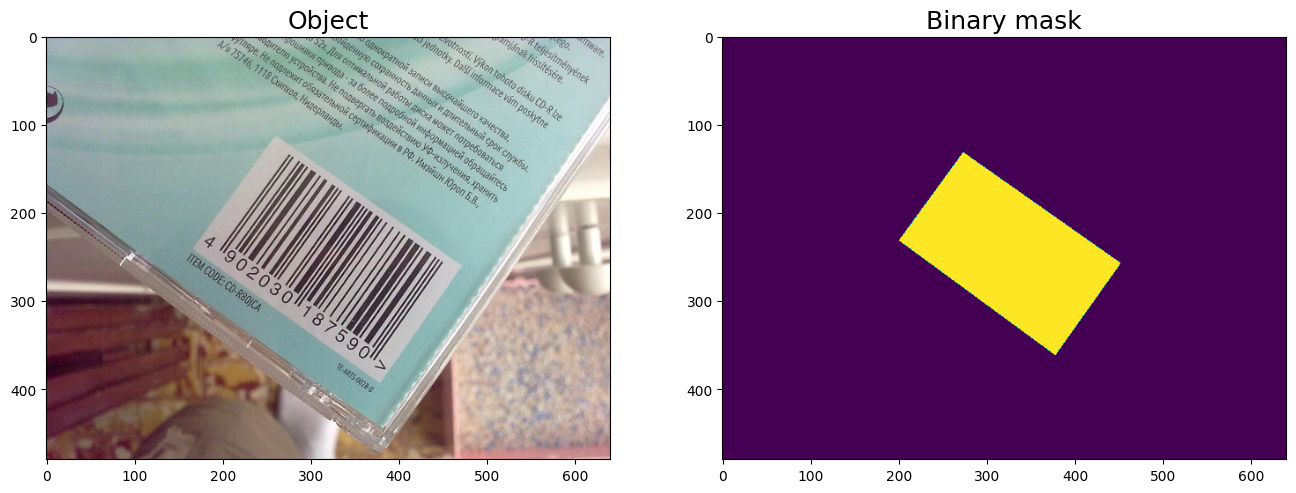

In [6]:
# Let's look at a random object and its binary mask

img_path = obj_dict[0]['images'][0]
mask_path = obj_dict[0]['masks'][0]

img, mask = get_img_and_mask(img_path, mask_path)

print("Image file:", img_path)
print("Mask file:", mask_path)
print("\nShape of the image of the object:", img.shape)
print("Shape of the binary mask:", mask.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img)
ax[0].set_title('Object', fontsize=18)
ax[1].imshow(mask)
ax[1].set_title('Binary mask', fontsize=18);

# 4. Resizing background images

In [8]:
def resize_img(img, desired_max, desired_min=None):
   
    h, w = img.shape[0], img.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = desired_max
    if desired_min:
        shortest_new = desired_min
    else:
        shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Compose([
        A.Sequential([
        A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)
        ], p=1)
    ])

    transformed = transform_resize(image=img)
    img_r = transformed["image"]
        
    return img_r

Shape of the original background image: (426, 640, 3)
Shape of the resized background image (desired_max=1920, desired_min=None): (1278, 1920, 3)
Shape of the resized background image (desired_max=1920, desired_min=1080): (1080, 1920, 3)


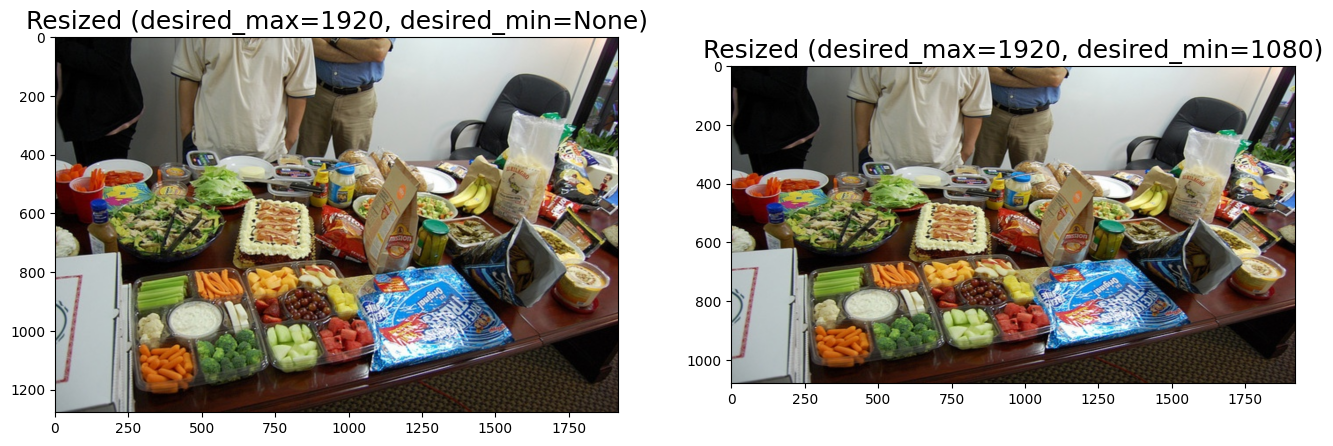

In [10]:
# Let's look how a random background image can be resized with resize_img() function

img_bg_path = files_bg_imgs[0]
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

img_bg_resized_1 = resize_img(img_bg, desired_max=1920, desired_min=None)
img_bg_resized_2 = resize_img(img_bg, desired_max=1920, desired_min=1080)

print("Shape of the original background image:", img_bg.shape)

print("Shape of the resized background image (desired_max=1920, desired_min=None):", img_bg_resized_1.shape)
print("Shape of the resized background image (desired_max=1920, desired_min=1080):", img_bg_resized_2.shape)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_bg_resized_1)
ax[0].set_title('Resized (desired_max=1920, desired_min=None)', fontsize=18)
ax[1].imshow(img_bg_resized_2)
ax[1].set_title('Resized (desired_max=1920, desired_min=1080)', fontsize=18);

# 5. Resizing and transforming objects

In [11]:
def resize_transform_obj(img, mask, longest_min, longest_max, transforms=False):
   
    h, w = mask.shape[0], mask.shape[1]
    
    longest, shortest = max(h, w), min(h, w)
    longest_new = np.random.randint(longest_min, longest_max)
    shortest_new = int(shortest * (longest_new / longest))
    
    if h > w:
        h_new, w_new = longest_new, shortest_new
    else:
        h_new, w_new = shortest_new, longest_new
        
    transform_resize = A.Resize(h_new, w_new, interpolation=1, always_apply=False, p=1)

    transformed_resized = transform_resize(image=img, mask=mask)
    img_t = transformed_resized["image"]
    mask_t = transformed_resized["mask"]
        
    if transforms:
        transformed = transforms(image=img_t, mask=mask_t)
        img_t = transformed["image"]
        mask_t = transformed["mask"]
        
    return img_t, mask_t

transforms_bg_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.ColorJitter(brightness=0.3,
                  contrast=0.3,
                  saturation=0.3,
                  hue=0.07,
                  always_apply=False,
                  p=1),
    A.Blur(blur_limit=(3,15),
           always_apply=False,
           p=0.5)
])

transforms_obj = A.Compose([
    A.RandomRotate90(p=1),
    A.RandomBrightnessContrast(brightness_limit=(-0.1, 0.2),
                               contrast_limit=0.1,
                               brightness_by_max=True,
                               always_apply=False,
                               p=1)
])

Shape of the image of the transformed object: (293, 391, 3)
Shape of the transformed binary mask: (293, 391)




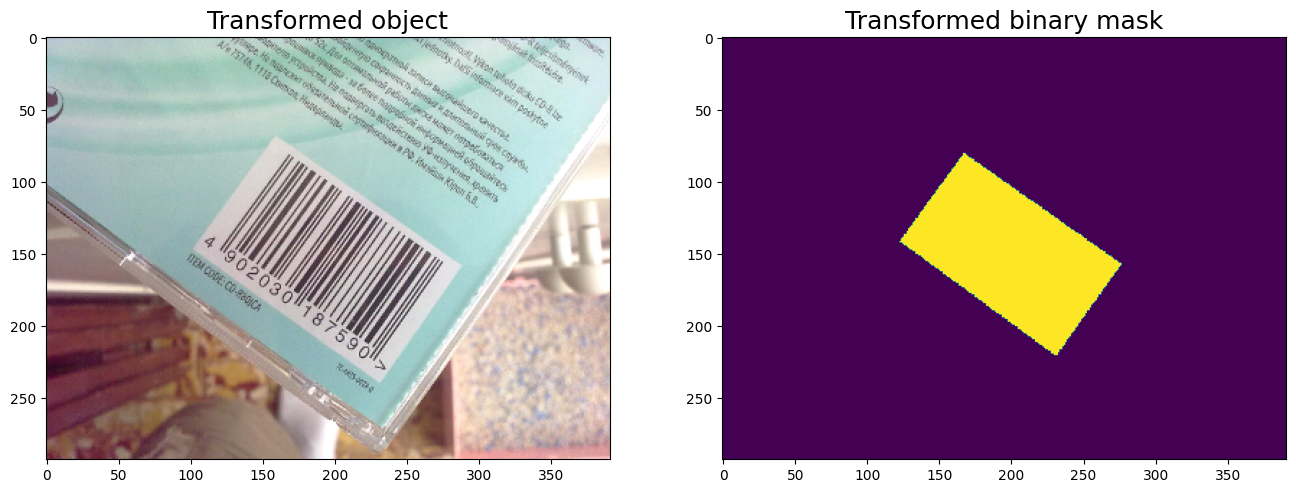

In [12]:
# Let's look how image and binary mask of a random object can be transformed
# with help of resize_transform_obj() function

img_path = obj_dict[0]['images'][0]
mask_path = obj_dict[0]['masks'][0]

img, mask = get_img_and_mask(img_path, mask_path)

img_t, mask_t = resize_transform_obj(img,
                                     mask,
                                     longest_min=300,
                                     longest_max=400,
                                     transforms=transforms_obj)

print("Shape of the image of the transformed object:", img_t.shape)
print("Shape of the transformed binary mask:", mask_t.shape)
print("\n")

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_t)
ax[0].set_title('Transformed object', fontsize=18)
ax[1].imshow(mask_t)
ax[1].set_title('Transformed binary mask', fontsize=18);

# 6. Adding object to background

In [13]:
def add_obj(img_comp, mask_comp, img, mask, x, y, idx):
    '''
    img_comp - composition of objects
    mask_comp - composition of objects` masks
    img - image of object
    mask - binary mask of object
    x, y - coordinates where center of img is placed
    Function returns img_comp in CV2 RGB format + mask_comp
    '''
    h_comp, w_comp = img_comp.shape[0], img_comp.shape[1]
    
    h, w = img.shape[0], img.shape[1]
    
    x = x - int(w/2)
    y = y - int(h/2)
    
    mask_b = mask == 1
    mask_rgb_b = np.stack([mask_b, mask_b, mask_b], axis=2)
    
    if x >= 0 and y >= 0:
    
        h_part = h - max(0, y+h-h_comp) # h_part - part of the image which gets into the frame of img_comp along y-axis
        w_part = w - max(0, x+w-w_comp) # w_part - part of the image which gets into the frame of img_comp along x-axis

        img_comp[y:y+h_part, x:x+w_part, :] = img_comp[y:y+h_part, x:x+w_part, :] * ~mask_rgb_b[0:h_part, 0:w_part, :] + (img * mask_rgb_b)[0:h_part, 0:w_part, :]
        mask_comp[y:y+h_part, x:x+w_part] = mask_comp[y:y+h_part, x:x+w_part] * ~mask_b[0:h_part, 0:w_part] + (idx * mask_b)[0:h_part, 0:w_part]
        mask_added = mask[0:h_part, 0:w_part]
        
    elif x < 0 and y < 0:
        
        h_part = h + y
        w_part = w + x
        
        img_comp[0:0+h_part, 0:0+w_part, :] = img_comp[0:0+h_part, 0:0+w_part, :] * ~mask_rgb_b[h-h_part:h, w-w_part:w, :] + (img * mask_rgb_b)[h-h_part:h, w-w_part:w, :]
        mask_comp[0:0+h_part, 0:0+w_part] = mask_comp[0:0+h_part, 0:0+w_part] * ~mask_b[h-h_part:h, w-w_part:w] + (idx * mask_b)[h-h_part:h, w-w_part:w]
        mask_added = mask[h-h_part:h, w-w_part:w]
        
    elif x < 0 and y >= 0:
        
        h_part = h - max(0, y+h-h_comp)
        w_part = w + x
        
        img_comp[y:y+h_part, 0:0+w_part, :] = img_comp[y:y+h_part, 0:0+w_part, :] * ~mask_rgb_b[0:h_part, w-w_part:w, :] + (img * mask_rgb_b)[0:h_part, w-w_part:w, :]
        mask_comp[y:y+h_part, 0:0+w_part] = mask_comp[y:y+h_part, 0:0+w_part] * ~mask_b[0:h_part, w-w_part:w] + (idx * mask_b)[0:h_part, w-w_part:w]
        mask_added = mask[0:h_part, w-w_part:w]
        
    elif x >= 0 and y < 0:
        
        h_part = h + y
        w_part = w - max(0, x+w-w_comp)
        
        img_comp[0:0+h_part, x:x+w_part, :] = img_comp[0:0+h_part, x:x+w_part, :] * ~mask_rgb_b[h-h_part:h, 0:w_part, :] + (img * mask_rgb_b)[h-h_part:h, 0:w_part, :]
        mask_comp[0:0+h_part, x:x+w_part] = mask_comp[0:0+h_part, x:x+w_part] * ~mask_b[h-h_part:h, 0:w_part] + (idx * mask_b)[h-h_part:h, 0:w_part]
        mask_added = mask[h-h_part:h, 0:w_part]
    
    return img_comp, mask_comp, mask_added

[0 1]


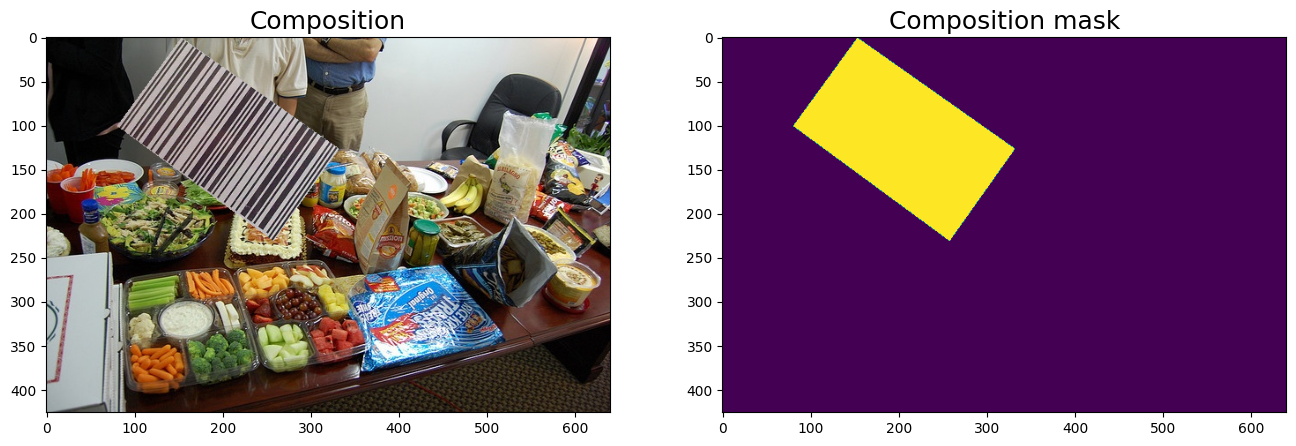

In [38]:
img_bg_path = files_bg_imgs[0]
img_bg = cv2.imread(img_bg_path)
img_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)

h, w = img_bg.shape[0], img_bg.shape[1]
mask_comp = np.zeros((h,w), dtype=np.uint8)

img_path = obj_dict[0]['images'][0]
mask_path = obj_dict[0]['masks'][0]
img, mask = get_img_and_mask(img_path, mask_path)
print(np.unique(mask))

img_comp, mask_comp, _ = add_obj(img_bg, mask_comp, img, mask, x=200, y=110, idx=2)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);

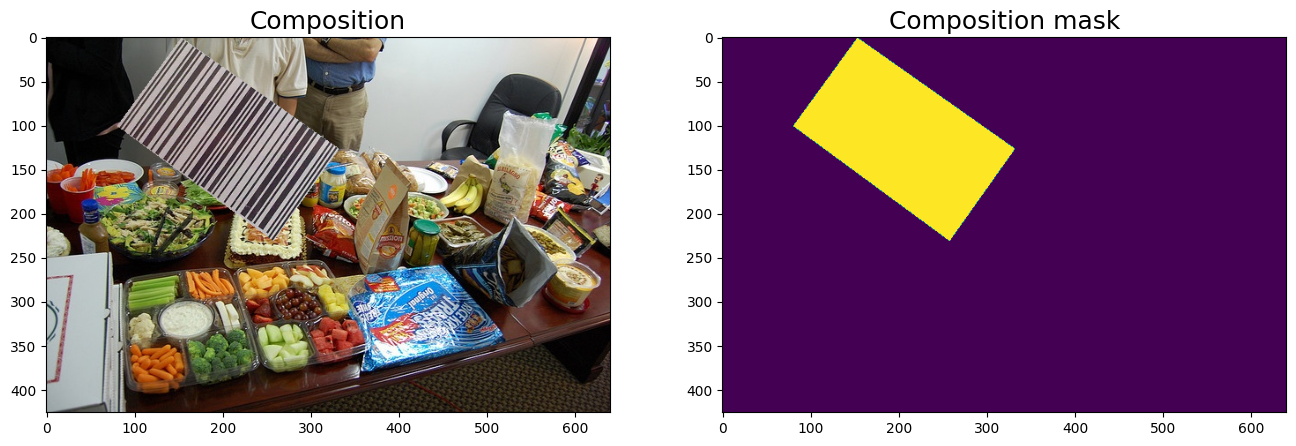

In [37]:
img_comp, mask_comp, _ = add_obj(img_comp, mask_comp, img, mask, x=200, y=110, idx=2)

fig, ax = plt.subplots(1, 2, figsize=(16, 7))
ax[0].imshow(img_comp)
ax[0].set_title('Composition', fontsize=18)
ax[1].imshow(mask_comp)
ax[1].set_title('Composition mask', fontsize=18);

# 7. Adding noise objects to background

In [39]:
def create_bg_with_noise(files_bg_imgs,
                         bg_max=1920,
                         bg_min=1080,
                         blank_bg=False):
    
    if blank_bg:
        img_comp_bg = np.ones((bg_min, bg_max,3), dtype=np.uint8) * 255
        mask_comp_bg = np.zeros((bg_min, bg_max), dtype=np.uint8)
    else:    
        idx = np.random.randint(len(files_bg_imgs))
        img_bg = cv2.imread(files_bg_imgs[idx])
        img_comp_bg = cv2.cvtColor(img_bg, cv2.COLOR_BGR2RGB)
        # img_comp_bg = resize_img(img_bg, bg_max, bg_min)
        mask_comp_bg = np.zeros((img_comp_bg.shape[0], img_comp_bg.shape[1]), dtype=np.uint8)

    # for i in range(1, np.random.randint(max_objs_to_add) + 2):
    #     idx = np.random.randint(len(files_bg_noise_imgs))
    #     img, mask = get_img_and_mask(files_bg_noise_imgs[idx], files_bg_noise_masks[idx])
    #     x, y = np.random.randint(img_comp_bg.shape[1]), np.random.randint(img_comp_bg.shape[0])
    #     img_t, mask_t = resize_transform_obj(img, mask, longest_bg_noise_min, longest_bg_noise_max, transforms=transforms_bg_obj)
    #     img_comp_bg, _, _ = add_obj(img_comp_bg, mask_comp_bg, img_t, mask_t, x, y, i)
        
    return img_comp_bg

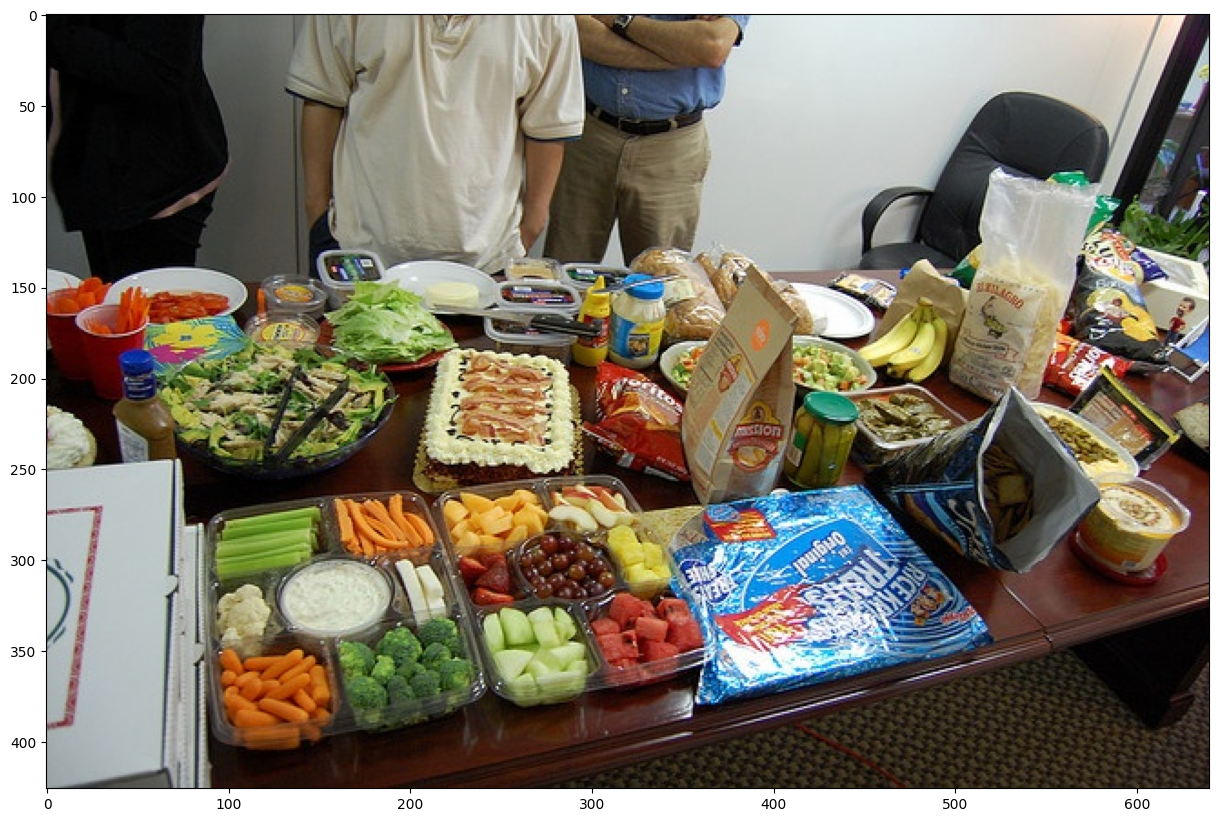

In [40]:
img_comp_bg = create_bg_with_noise(files_bg_imgs,blank_bg=False)
plt.figure(figsize=(15,15))
plt.imshow(img_comp_bg)

# 8. Controlling degree of overlapping

In [41]:
def check_areas(mask_comp, obj_areas, overlap_degree=0.3):
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:-1]
    masks = mask_comp == obj_ids[:, None, None]
    
    ok = True
    
    if len(np.unique(mask_comp)) != np.max(mask_comp) + 1:
        ok = False
        return ok
    
    for idx, mask in enumerate(masks):
        if np.count_nonzero(mask) / obj_areas[idx] < 1 - overlap_degree:
            ok = False
            break
            
    return ok

# 9. Creating synthetic composition

In [52]:
def create_composition(img_comp_bg,
                       max_objs=3,
                       overlap_degree=0,
                       max_attempts_per_obj=10):

    img_comp = img_comp_bg.copy()
    h, w = img_comp.shape[0], img_comp.shape[1]
    mask_comp = np.zeros((h,w), dtype=np.uint8)
    
    obj_areas = []
    labels_comp = []
    num_objs = np.random.randint(max_objs) + 2
    i = 1
    
    for _ in range(1, num_objs):

        obj_idx = np.random.randint(len(obj_dict)) + 1
        
        for _ in range(max_attempts_per_obj):

            imgs_number = len(obj_dict[0]['images'])
            idx = np.random.randint(imgs_number)
            img_path = obj_dict[0]['images'][idx]
            mask_path = obj_dict[0]['masks'][idx]
            img, mask = get_img_and_mask(img_path, mask_path)

            x, y = np.random.randint(low=70, high=w+70), np.random.randint(low=50, high=h-50)
            longest_min = obj_dict[0]['longest_min']
            longest_max = obj_dict[0]['longest_max']
            img, mask = resize_transform_obj(img,
                                             mask,
                                             longest_min,
                                             longest_max,
                                             transforms=transforms_obj)

            if i == 1:
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                obj_areas.append(np.count_nonzero(mask_added))
                labels_comp.append(obj_idx)
                i += 1
                break
            else:        
                img_comp_prev, mask_comp_prev = img_comp.copy(), mask_comp.copy()
                img_comp, mask_comp, mask_added = add_obj(img_comp,
                                                          mask_comp,
                                                          img,
                                                          mask,
                                                          x,
                                                          y,
                                                          i)
                ok = check_areas(mask_comp, obj_areas, overlap_degree)
                if ok:
                    obj_areas.append(np.count_nonzero(mask_added))
                    labels_comp.append(obj_idx)
                    i += 1
                    break
                else:
                    img_comp, mask_comp = img_comp_prev.copy(), mask_comp_prev.copy()        
        
    return img_comp, mask_comp, labels_comp, obj_areas

Labels (classes of the objects) on the composition in order of object's addition: [1, 1]


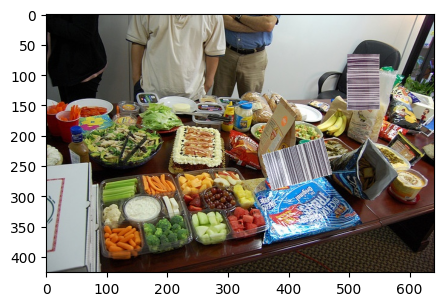

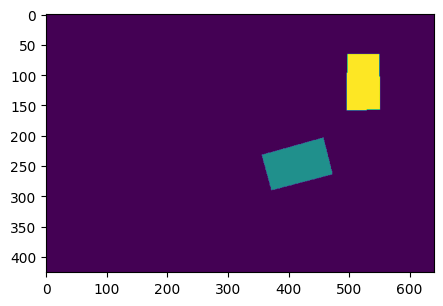

In [128]:
img_comp, mask_comp, labels_comp, obj_areas = create_composition(img_comp_bg,
                                                                 max_objs=2,
                                                                 overlap_degree=1,
                                                                 max_attempts_per_obj=10)
plt.figure(figsize=(5,15))
plt.imshow(img_comp)

plt.figure(figsize=(5,5))
plt.imshow(mask_comp)

print("Labels (classes of the objects) on the composition in order of object's addition:", labels_comp)

In [129]:
obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
masks = mask_comp == obj_ids[:, None, None]

print("Degree of how much area of each object is overlapped:")

for idx, mask in enumerate(masks):
    print(np.count_nonzero(mask) / obj_areas[idx])

Degree of how much area of each object is overlapped:
1.0
1.0


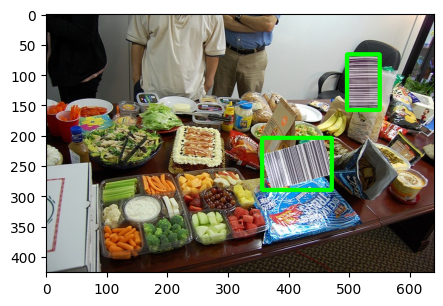

In [130]:
colors = {0: (255,0,0), 1: (0,255,0), 2: (0,0,255)}

img_comp_bboxes = img_comp.copy()

obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
# obj_ids = np.array([1], dtype=np.uint8)
masks = mask_comp == obj_ids[:, None, None]


for i in range(len(obj_ids)):
    pos = np.where(masks[i])
    xmin = np.min(pos[1])
    xmax = np.max(pos[1])
    ymin = np.min(pos[0])
    ymax = np.max(pos[0])
    img_comp_bboxes = cv2.rectangle(img_comp_bboxes,
                                    (xmin, ymin),
                                    (xmax,ymax),
                                    colors[labels_comp[i]],
                                    6)
    
plt.figure(figsize=(5,5))
plt.imshow(img_comp_bboxes) 

# 10. Annotations in YOLO format

In [114]:
def create_yolo_annotations(mask_comp, labels_comp):
    comp_w, comp_h = mask_comp.shape[1], mask_comp.shape[0]
    
    obj_ids = np.unique(mask_comp).astype(np.uint8)[1:]
    # obj_ids = np.array([1], dtype=np.uint8)
    masks = mask_comp == obj_ids[:, None, None]
    annotations_yolo = []
    for i in range(len(labels_comp)):
        pos = np.where(masks[i])
        xmin = np.min(pos[1])
        xmax = np.max(pos[1])
        ymin = np.min(pos[0])
        ymax = np.max(pos[0])

        xc = (xmin + xmax) / 2
        yc = (ymin + ymax) / 2
        w = xmax - xmin
        h = ymax - ymin

        annotations_yolo.append([labels_comp[i] - 1,
                                round(xc/comp_w, 5),
                                round(yc/comp_h, 5),
                                round(w/comp_w, 5),
                                round(h/comp_h, 5)])

    return annotations_yolo

In [115]:
annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
for i in range(len(annotations_yolo)):
    print(' '.join(str(el) for el in annotations_yolo[i]))

0 0.16328 0.31455 0.24531 0.37089
0 0.62031 0.38732 0.1125 0.28638


# 11. Creating and saving synthetic dataset

In [ ]:
def generate_dataset(imgs_number, folder, split='train'):
    time_start = time.time()
    for j in tqdm(range(imgs_number)):
        img_comp_bg = create_bg_with_noise(files_bg_imgs)
        
        img_comp, mask_comp, labels_comp, _ = create_composition(img_comp_bg,
                                                                 max_objs=1,
                                                                 overlap_degree=1,
                                                                 max_attempts_per_obj=20)
        img_comp = cv2.cvtColor(img_comp, cv2.COLOR_RGB2BGR)
        cv2.imwrite(os.path.join(folder, split, 'images/{}.jpg').format(j), img_comp)
        annotations_yolo = create_yolo_annotations(mask_comp, labels_comp)
        for i in range(len(annotations_yolo)):
            with open(os.path.join(folder, split, 'labels/{}.txt').format(j), "a") as f:
                f.write(' '.join(str(el) for el in annotations_yolo[i]) + '\n')
                
    time_end = time.time()
    time_total = round(time_end - time_start)
    time_per_img = round((time_end - time_start) / imgs_number, 1)
    
    print("Generation of {} synthetic images is completed. It took {} seconds, or {} seconds per image".format(imgs_number, time_total, time_per_img))
    print("Images are stored in '{}'".format(os.path.join(folder, split, 'images')))
    print("Annotations are stored in '{}'".format(os.path.join(folder, split, 'labels')))

In [ ]:
generate_dataset(1000, folder='dataset', split='train')
generate_dataset(200, folder='dataset', split='valid')